In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

from functools import partial

import param_scan


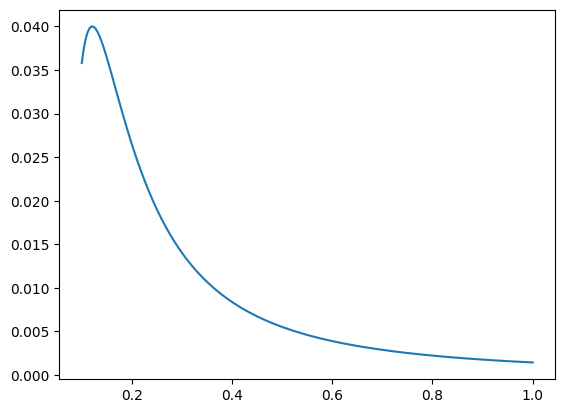

In [3]:
# Test the probabilities
theta = {"g": 1, "m4": np.sqrt(0.3), "Ue4Sq": 1e-1, "Um4Sq": 1e-1}
sterile = param_scan.Sterile(theta, decouple_decay=False, oscillations=True, decay=False)
# sterile.Ldec(0.2)
# sterile.Losc(0.3)
E = np.linspace(0.1, 1, 1000)
L = 0.5
plt.plot(E, sterile.Pme(E,E,L))

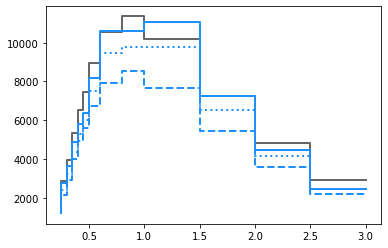

In [63]:
# NuE spectra as a function of true energy, w/o and w/ new physics.
MuB_True_BinEdges = [
    0.200,
    0.250,
    0.300,
    0.350,
    0.400,
    0.450,
    0.500,
    0.600,
    0.800,
    1.000,
    1.500,
    2.000,
    2.500,
    3.000,
]
MCT = [77.71578947, 143.90340557, 196.07832817, 267.13560372, 327.16160991,
  373.37368421, 894.8247678, 2112.43839009, 2272.64024768, 5099.22910217,
3630.38080495, 2404.02167183, 1456.92260062]
#theta = {"g": 1, "m4": 100, "Ue4Sq": 1e-1, "Um4Sq": 5e-1}
theta = {"g": 1, "m4": 100, "Ue4Sq": 5e-1, "Um4Sq": 0.0}
sterile = param_scan.Sterile(theta, decouple_decay=False, oscillations=True, decay=True)
# sterile.Ldec(0.2)
# sterile.Losc(0.3)
Ebin = np.linspace(0, 3, 51)
L = 0.5
PeeRW = []
PeeRWn1 = []

PeeRW_deg = np.zeros((len(MCT), len(MCT)))
PeeRW_degn1 = np.zeros((len(MCT), len(MCT)))
PeeRW_osc = []
# degradation piece
for k in range(len(MCT)):
    for i in range(k + 1):
        Peedecay = sterile.Peedecay(MuB_True_BinEdges[k], MuB_True_BinEdges[k + 1], MuB_True_BinEdges[i], MuB_True_BinEdges[i + 1], L, noffset=0)
        PeeRW_deg[k][i] = Peedecay * MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i])

        Peedecayn1 = sterile.Peedecay(MuB_True_BinEdges[k], MuB_True_BinEdges[k + 1], MuB_True_BinEdges[i], MuB_True_BinEdges[i + 1], L, noffset=10000)
        PeeRW_degn1[k][i] = Peedecayn1 * MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i])
PeeRW_sum = np.sum(PeeRW_deg, axis=0)
PeeRW_sumn1 = np.sum(PeeRW_degn1, axis=0)

# oscillation piece
for i in range(len(MCT)):
    Peeosc = sterile.Peeosc(MuB_True_BinEdges[i], MuB_True_BinEdges[i + 1], L)
    PeeRW_osc.append(Peeosc * MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i]))

# Normalize MCT-event rate/GeV
MCT_norm = []
for i in range(len(MCT)):
    MCT_norm.append(MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i]))
PeeRW = PeeRW_sum + PeeRW_osc
PeeRWn1 = PeeRW_sumn1 + PeeRW_osc



#PeeRW_unnorm = sterile.EnergyDegradation(MCT, MuB_True_BinEdges, 'Pee')
plt.step(MuB_True_BinEdges[1:], MCT_norm, color='#666666', ls='-', lw=2)
plt.step(MuB_True_BinEdges[1:], PeeRW, color='dodgerblue', ls='-', lw=2)
plt.step(MuB_True_BinEdges[1:], PeeRWn1, color='dodgerblue', ls=':', lw=2)
plt.step(MuB_True_BinEdges[1:], PeeRW_osc, color='dodgerblue', ls='--', lw=2)
#plt.step(MuB_True_BinEdges[1:], PeeRW_unnorm)
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum1, label = 'n = 1 (default)')
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum2, label = 'n = 2')
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum3, label = 'n = 3')
#plt.xlabel('True energy(GeV)')
#plt.ylabel('Events/GeV')
#plt.title('NuE spectrum (decay term) with different degradation power(n)')
#plt.legend()

#plt.step(MuB_True_BinEdges[1:], PeeRW_osc)
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[5])
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[7])
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[9])

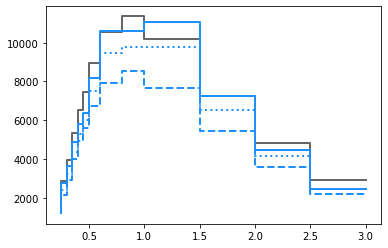

In [32]:
# NuE spectra as a function of true energy, w/o and w/ new physics.
MuB_True_BinEdges = [
    0.200,
    0.250,
    0.300,
    0.350,
    0.400,
    0.450,
    0.500,
    0.600,
    0.800,
    1.000,
    1.500,
    2.000,
    2.500,
    3.000,
]
MCT = [77.71578947, 143.90340557, 196.07832817, 267.13560372, 327.16160991,
  373.37368421, 894.8247678, 2112.43839009, 2272.64024768, 5099.22910217,
3630.38080495, 2404.02167183, 1456.92260062]
#theta = {"g": 1, "m4": 100, "Ue4Sq": 1e-1, "Um4Sq": 5e-1}
theta = {"g": 1, "m4": 100, "Ue4Sq": 5e-1, "Um4Sq": 0.0}
sterile = param_scan.Sterile(theta, decouple_decay=False, oscillations=True, decay=True)
# sterile.Ldec(0.2)
# sterile.Losc(0.3)
Ebin = np.linspace(0, 3, 51)
L = 0.5
PeeRW = []
PeeRWn1 = []

PeeRW_deg = np.zeros((len(MCT), len(MCT)))
PeeRW_degn1 = np.zeros((len(MCT), len(MCT)))
PeeRW_osc = []
# degradation piece
for k in range(len(MCT)):
    for i in range(k + 1):
        Peedecay = sterile.Peedecay(MuB_True_BinEdges[k], MuB_True_BinEdges[k + 1], MuB_True_BinEdges[i], MuB_True_BinEdges[i + 1], L, noffset=0)
        PeeRW_deg[k][i] = Peedecay * MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i])

        Peedecayn1 = sterile.Peedecay(MuB_True_BinEdges[k], MuB_True_BinEdges[k + 1], MuB_True_BinEdges[i], MuB_True_BinEdges[i + 1], L, noffset=10000)
        PeeRW_degn1[k][i] = Peedecayn1 * MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i])
PeeRW_sum = np.sum(PeeRW_deg, axis=0)
PeeRW_sumn1 = np.sum(PeeRW_degn1, axis=0)

# oscillation piece
for i in range(len(MCT)):
    Peeosc = sterile.Peeosc(MuB_True_BinEdges[i], MuB_True_BinEdges[i + 1], L)
    PeeRW_osc.append(Peeosc * MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i]))

# Normalize MCT-event rate/GeV
MCT_norm = []
for i in range(len(MCT)):
    MCT_norm.append(MCT[i] / (MuB_True_BinEdges[i + 1] - MuB_True_BinEdges[i]))
PeeRW = PeeRW_sum + PeeRW_osc
PeeRWn1 = PeeRW_sumn1 + PeeRW_osc



#PeeRW_unnorm = sterile.EnergyDegradation(MCT, MuB_True_BinEdges, 'Pee')
plt.step(MuB_True_BinEdges[1:], MCT_norm, color='#666666', ls='-', lw=2)
plt.step(MuB_True_BinEdges[1:], PeeRW, color='dodgerblue', ls='-', lw=2)
plt.step(MuB_True_BinEdges[1:], PeeRWn1, color='dodgerblue', ls=':', lw=2)
plt.step(MuB_True_BinEdges[1:], PeeRW_osc, color='dodgerblue', ls='--', lw=2)
#plt.step(MuB_True_BinEdges[1:], PeeRW_unnorm)
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum1, label = 'n = 1 (default)')
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum2, label = 'n = 2')
#plt.step(MuB_True_BinEdges[1:], PeeRW_sum3, label = 'n = 3')
#plt.xlabel('True energy(GeV)')
#plt.ylabel('Events/GeV')
#plt.title('NuE spectrum (decay term) with different degradation power(n)')
#plt.legend()
#plt.gca().axis([0.5, 1.5, 8000, 12000])
#plt.step(MuB_True_BinEdges[1:], PeeRW_osc)
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[5])
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[7])
#plt.step(MuB_True_BinEdges[1:], PeeRW_deg[9])

[0.003625   0.005875   0.008125   ... 0.01937505 0.02162505 0.02387505]


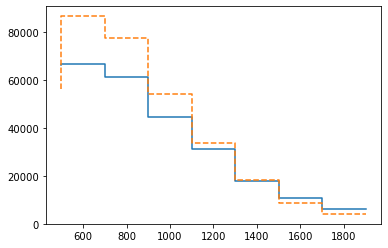

In [66]:
MiniBooNE_Signal = np.genfromtxt('/Users/taozhou/Documents/GitHub/muB_oscillation/MiniTools/include/MB_data_release/fhcmode/miniboone_numunuefullosc_ntuple.txt')
LMBT = 0.4685  # Baseline length in kilometers
NREPLICATION = 10
Ereco = MiniBooNE_Signal[:, 0] / 1000  # GeV
Etrue = MiniBooNE_Signal[:, 1] / 1000  # GeV
Weight = MiniBooNE_Signal[:, 3] / len(MiniBooNE_Signal[:, 3])
e_prod_e_int_bins = np.linspace(0, 3, 51)  # GeV
Length = MiniBooNE_Signal[:, 2] / 100000  # Kilometers
theta = {"g": 1, "m4": 100, "Ue4Sq": 5e-2, "Um4Sq": 0.05}
sterile = param_scan.Sterile(theta, decouple_decay=False, oscillations=True, decay=True)
nue_bin_edges = np.array([200.0, 300.0, 375.0, 475.0, 550.0, 675.0, 800.0, 950.0, 1100.0, 1250.0, 1500.0, 3000.0])
nue_reco_dist = [527.164624, 315.423689, 349.644825, 186.211970, 261.441799, 195.534193, 203.008745, 165.664396, 118.581365, 143.989367, 201.450357]  
numu_bin_edges = np.array([0, 0.5, 0.7, 0.9, 1.1, 1.3, 1.50, 1.7, 1.9]) * 1e3  # MeV
numu_reco_dist = [56314.570151, 86652.16900, 77496.377767, 54280.574682, 33589.592857, 18141.591625, 8780.439580, 4090.676535]

def create_e_daughter(e_prod, n_replications=NREPLICATION):
    # e_prod: parent neutrino energy
    de = e_prod / n_replications
    return np.linspace(de / 2, e_prod - de / 2, n_replications)


def create_Etrue_and_Weight_int(n_replications=NREPLICATION):
    # For every Etrue, create a list of possible daughter neutrino energy
    Etrue_daughter = np.array(
        [create_e_daughter(e, n_replications=n_replications) for e in Etrue]
    )
    Etrue_extended = np.stack([Etrue for _ in range(n_replications)], axis=0).T

    return Etrue_extended.flatten(), Etrue_daughter.flatten()


# Replicating events for multiple daughter neutrino energies
Etrue_parent, Etrue_daughter = create_Etrue_and_Weight_int()

# replicating entries of the MC data release -- baseline L and weight
Length_ext = np.stack([Length for _ in range(NREPLICATION)], axis=0).T.flatten()
Weight_ext = np.stack(
    [Weight / NREPLICATION for _ in range(NREPLICATION)], axis=0
).T.flatten()

# Flavor transition probabilities -- Assuming nu4 decays only into nue
Pme = sterile.Pme(Etrue_parent, Etrue_daughter, Length_ext)
print(Pme)
Weight_decay = Weight_ext * Pme
Ree_true = np.histogram(Etrue_daughter, bins=e_prod_e_int_bins, weights=Weight_decay)[0]
Rmm_true = np.histogram(Etrue, bins=e_prod_e_int_bins, weights=Weight)[0]
migration_matrix_pee = param_scan.create_reco_migration_matrix(nue_bin_edges/1e3)
migration_matrix_pmm = param_scan.create_reco_migration_matrix(numu_bin_edges/1e3)
Ree_reco = np.dot(Ree_true, migration_matrix_pee)
Rmm_reco = np.dot(Rmm_true, migration_matrix_pmm)
#plt.step(nue_bin_edges[1:], Ree_reco, ls='-')
#plt.step(nue_bin_edges[1:], nue_reco_dist, ls='--')

plt.step(numu_bin_edges[1:], Rmm_reco, ls='-')
plt.step(numu_bin_edges[1:], numu_reco_dist, ls='--')
P_ee_avg = [sterile.PeeAvg(nue_bin_edges[i], nue_bin_edges[i+1], LMBT) for i in range(len(nue_bin_edges)-1)]

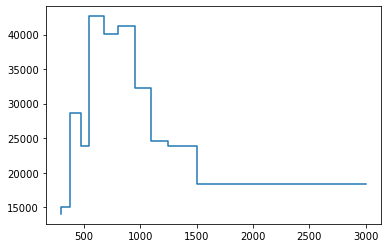

In [35]:
plt.step(nue_bin_edges[1:], Ree_reco, ls='-')

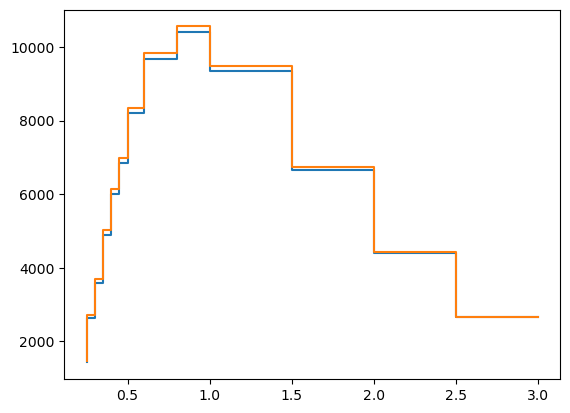

In [5]:
# NuE spectra w/ and w/o energy degradation
PeeRW_old = []
for k in range(len(MCT)):
    RWFact = sterile.PeeAvg(MuB_True_BinEdges[k], MuB_True_BinEdges[k + 1], L)
    PeeRW_old.append(MCT[k] * RWFact / (MuB_True_BinEdges[k + 1] - MuB_True_BinEdges[k]))
plt.step(MuB_True_BinEdges[1:], PeeRW_old)
plt.step(MuB_True_BinEdges[1:], PeeRW)

## Run some scans

In [1]:
def create_grid_of_params(g, m4, Ue4Sq, Um4Sq):
    paramlist_decay = np.array(np.meshgrid(g, m4, Ue4Sq, Um4Sq)).T.reshape(-1, 4)
    return [{"g": g, "m4": m4, "Ue4Sq": Ue4Sq, "Um4Sq": Um4Sq} for g, m4, Ue4Sq, Um4Sq in paramlist_decay]

### 2D scans

De Gouvea's case

In [10]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 10

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4, 0.9, Npoints)

# Range of gm4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=1, m4=y_Vec, Ue4Sq=1e-1, Um4Sq=x_Vec)

func_2Dscan_deGouvea = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=False, decay=True, decouple_decay=True)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_2Dscan_deGouvea, paramlist_decay)
np.save(f"{path_results}/App_gm4_Um4sq_deGouvea", res)

Pure oscillation case

In [75]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4, 0.9, Npoints)

# Range of m4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=0.01, m4=y_Vec, Ue4Sq=5e-2, Um4Sq=x_Vec)

# Pure oscillation method
func_2Dscan_osc = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=True)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_2Dscan_osc, paramlist_decay)
np.save(f"{path_results}/App_gm4_Um4sq_osc_decay_deg_g=0.01_Ue4Sq=0.05", res)

In [6]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 3-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 3

# Range of gm4 for sterile decay model scanned over 0.1 to 1000
gm_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 1
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=1, m4=gm_Vec, Ue4Sq=e_Vec, Um4Sq=mu_Vec)

# Pure oscillation method
func_3Dscan_decay = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=True)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_3Dscan_decay, paramlist_decay)
np.save(f"{path_results}/App_gm4_Ue4sq_Um4sq_test", res)

In [ ]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 4-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of gm4 for sterile decay model scanned over 0.1 to 1000
g_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Range of m4 for sterile decay model scanned over 10 to 1000 eV
m_Vec = np.geomspace(1e1, 1e3, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 1
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=g_Vec, m4=m_Vec, Ue4Sq=e_Vec, Um4Sq=mu_Vec)

# Pure oscillation method
func_3Dscan_decay = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=True)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_3Dscan_decay, paramlist_decay)
np.save(f"{path_results}/App_g_m4_Ue4sq_Um4sq_v1", res)

### Deprecated

THis code needs to adapted to the method above.

In [73]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 3-dimensions
# --------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of gm4 for sterile decay model scanned over 0.1 to 100
gm_Vec = np.geomspace(1e-1, 1e3, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 1
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(gm_Vec, e_Vec, mu_Vec)).T.reshape(-1, 3)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_3D, paramlist_decay)
np.save(f"{path_results}/App_gm4_Ue4sq_Um4sq_migrated_v3_15*15*15", res)

[[1.00000000e-01 1.00000000e-04 1.00000000e-04]
 [1.00000000e-01 1.83478607e-04 1.00000000e-04]
 [1.00000000e-01 3.36643992e-04 1.00000000e-04]
 ...
 [1.00000000e+05 1.45554357e-01 4.90000000e-01]
 [1.00000000e+05 2.67061108e-01 4.90000000e-01]
 [1.00000000e+05 4.90000000e-01 4.90000000e-01]]


In [72]:
# ---------------------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 3-dimensions with 1 parameter fixed
# ---------------------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of gm4 for sterile decay model scanned over 0.1 to 100 in 30 steps
gm_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(gm_Vec, 1e-1, mu_Vec)).T.reshape(-1, 3)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_3D, paramlist_decay)
np.save(f"{path_results}/Fixed_Ue4sq_1e-2_15*15_v3", res)

[[1.00000000e-01 1.00000000e-01 1.00000000e-04]
 [1.63789371e-01 1.00000000e-01 1.00000000e-04]
 [2.68269580e-01 1.00000000e-01 1.00000000e-04]
 [4.39397056e-01 1.00000000e-01 1.00000000e-04]
 [7.19685673e-01 1.00000000e-01 1.00000000e-04]
 [1.17876863e+00 1.00000000e-01 1.00000000e-04]
 [1.93069773e+00 1.00000000e-01 1.00000000e-04]
 [3.16227766e+00 1.00000000e-01 1.00000000e-04]
 [5.17947468e+00 1.00000000e-01 1.00000000e-04]
 [8.48342898e+00 1.00000000e-01 1.00000000e-04]
 [1.38949549e+01 1.00000000e-01 1.00000000e-04]
 [2.27584593e+01 1.00000000e-01 1.00000000e-04]
 [3.72759372e+01 1.00000000e-01 1.00000000e-04]
 [6.10540230e+01 1.00000000e-01 1.00000000e-04]
 [1.00000000e+02 1.00000000e-01 1.00000000e-04]
 [1.00000000e-01 1.00000000e-01 1.83478607e-04]
 [1.63789371e-01 1.00000000e-01 1.83478607e-04]
 [2.68269580e-01 1.00000000e-01 1.83478607e-04]
 [4.39397056e-01 1.00000000e-01 1.83478607e-04]
 [7.19685673e-01 1.00000000e-01 1.83478607e-04]
 [1.17876863e+00 1.00000000e-01 1.834786

In [69]:
# ---------------------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 4-dimensions with 1 parameter fixed
# ---------------------------------------------------------------------------------------------
path_results = "fit_data/"
Npoints = 15

m4 = 1e3

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 0.5 in 15 steps
mu_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Range of g for sterile decay model scanned over 0.1 to 100 in 15 steps
g_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 0.5 in 15 steps
e_Vec = np.geomspace(1e-4, 0.49, Npoints)

# Cartesian product of grid
paramlist_decay = np.array(np.meshgrid(g_Vec, m4, e_Vec, mu_Vec)).T.reshape(-1, 4)
print(paramlist_decay)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(param_scan.DecayReturnMicroBooNEChi2_4D, paramlist_decay)
np.save(f"{path_results}/Fixed_m4_1e3_15*15*15_v1", res)

[[1.00000000e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 [1.63789371e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 [2.68269580e-01 1.00000000e+03 1.00000000e-04 1.00000000e-04]
 ...
 [3.72759372e+01 1.00000000e+03 4.90000000e-01 4.90000000e-01]
 [6.10540230e+01 1.00000000e+03 4.90000000e-01 4.90000000e-01]
 [1.00000000e+02 1.00000000e+03 4.90000000e-01 4.90000000e-01]]
